In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
output = 'radio_data.npz'

f = np.load(output)


In [3]:
n_train  = 40000

x_train,x_test = f['traces'][:n_train],f['traces'][n_train:]
signals = f['signals']
labels = (signals.std(axis=-1) != 0).astype(float)  # define training label (1=cosmic event, 0=noise)
y_train, y_test = labels[:n_train], labels[n_train:]

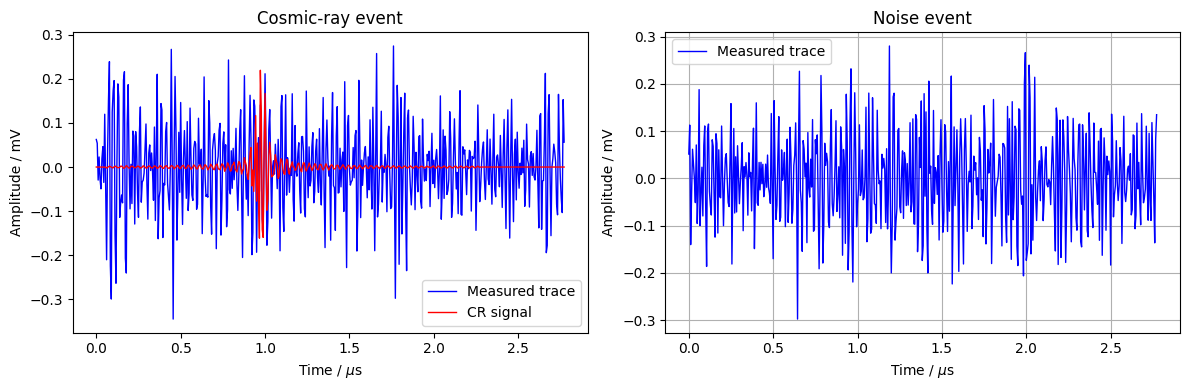

In [4]:
fs = 180e6  # Sampling frequency of antenna setup 180 MHz
t = np.arange(500) / fs * 1e6
idx = np.random.randint(0, labels.sum()-1)
idx2 =  np.random.randint(0, n_train - labels.sum())

plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(t, np.real(f["traces"][labels.astype(bool)][idx]), linewidth = 1, color="b", label="Measured trace")
plt.plot(t, np.real(signals[labels.astype(bool)][idx]), linewidth = 1, color="r", label="CR signal")
plt.ylabel('Amplitude / mV')
plt.xlabel('Time / $\mu \mathrm{s}$')
plt.legend()
plt.title("Cosmic-ray event")
plt.subplot(1, 2, 2)

plt.plot(t, np.real(x_train[~y_train.astype(bool)][idx2]), linewidth = 1, color="b", label="Measured trace")
plt.ylabel('Amplitude / mV')
plt.xlabel('Time / $\mu \mathrm{s}$')
plt.legend()
plt.title("Noise event")

plt.grid(True)
plt.tight_layout()

In [5]:
sigma = x_train.std()
x_train /= sigma
x_test /= sigma

In [6]:
print(x_train.shape)
print(y_train.shape)

(40000, 500)
(40000,)


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader


In [27]:
class model2(nn.Module):
    def __init__(self):
        super(model2, self).__init__()

        # Layers
        self.LSTM_b_1 = nn.LSTM(1, 32, 1, batch_first=True, bidirectional=True)  # Input size should be 1
        self.LSTM_b_2 = nn.LSTM(64, 64, 1, batch_first=True, bidirectional=True)
        self.LSTM_b_3 = nn.LSTM(128, 10, 1, batch_first=True, bidirectional=True)
        
        self.FC = nn.Linear(500*20, 1)

    def forward(self, x):
        out, _ = self.LSTM_b_1(x.unsqueeze(-1))
        out, _ = self.LSTM_b_2(out)
        out, _ = self.LSTM_b_3(out)
        out = out.contiguous().view(out.size(0), -1)  # Flatten
        out = self.FC(out)
        out = torch.sigmoid(out)
        return out


In [28]:
if type(x_train) == np.ndarray:
    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).float()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).float()

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# model = model3(input_size, hidden_sizes, num_layers, dropout_rate, output_size).to(device)
model = model2().to(device)
print(model)
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.1)


epochs = 50
train_loss = []
test_loss = []


cuda:0
model2(
  (LSTM_b_1): LSTM(1, 32, batch_first=True, bidirectional=True)
  (LSTM_b_2): LSTM(64, 64, batch_first=True, bidirectional=True)
  (LSTM_b_3): LSTM(128, 10, batch_first=True, bidirectional=True)
  (FC): Linear(in_features=10000, out_features=1, bias=True)
)


In [29]:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    batchN = 0
    batchT = len(train_loader)

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        output = model(x)
        # print(x.shape)
        # print(output.shape)
        # print(y.shape)
        loss = criterion(output, y.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        batchN += 1
        print(f"\rEpoch: {epoch+1}/{epochs}, Batch: {batchN}/{batchT}, Loss: {loss.item():.6f}",end="")
    #     break
    # break
    scheduler.step(loss)
    train_loss.append(epoch_loss / len(train_loader))

Epoch: 50/50, Batch: 157/157, Loss: 0.489731

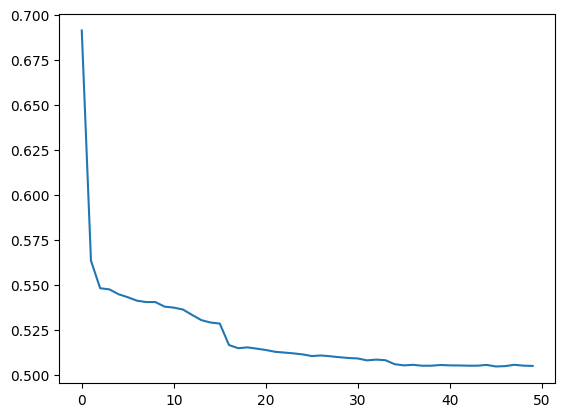

In [30]:
plt.plot(train_loss)

In [32]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

# Define learning rate scheduler and early stopping parameters
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, verbose=True, min_lr=1e-5)
n_epochs_stop = 15
epochs_no_improve = 0
min_val_loss = np.Inf

val_losses = []
train_losses = []


# Training loop
for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    model.train()  # put model in training mode
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    # Normalizing the loss by the total number of train batches
    running_loss /= len(train_loader)
    # print(f'Training Loss: {running_loss}')

    # Calculate validation loss
    val_loss = 0.0
    scheduler.step(running_loss)
    train_losses.append(running_loss)

    print(f'Epoch: {epoch+1} \tTraining Loss: {running_loss} \tValidation Loss: {val_loss}')

print('Finished Training')


Epoch: 1 	Training Loss: 0.516316738288114 	Validation Loss: 0.0
Epoch: 2 	Training Loss: 0.5136066361977036 	Validation Loss: 0.0
Epoch: 3 	Training Loss: 0.5117496787362797 	Validation Loss: 0.0
Epoch: 4 	Training Loss: 0.5062273313665087 	Validation Loss: 0.0
Epoch: 5 	Training Loss: 0.5058729058238352 	Validation Loss: 0.0
Epoch: 6 	Training Loss: 0.5012811297064375 	Validation Loss: 0.0
Epoch: 7 	Training Loss: 0.4954132585768487 	Validation Loss: 0.0
Epoch: 8 	Training Loss: 0.4924532230112963 	Validation Loss: 0.0
Epoch: 9 	Training Loss: 0.4859418916474482 	Validation Loss: 0.0
Epoch: 10 	Training Loss: 0.48248668897683455 	Validation Loss: 0.0
Epoch: 11 	Training Loss: 0.4752026570450728 	Validation Loss: 0.0
Epoch: 12 	Training Loss: 0.46761165303029834 	Validation Loss: 0.0
Epoch: 13 	Training Loss: 0.4616203349866685 	Validation Loss: 0.0
Epoch: 14 	Training Loss: 0.4568059338126213 	Validation Loss: 0.0
Epoch: 15 	Training Loss: 0.4485856957116704 	Validation Loss: 0.0
Epo

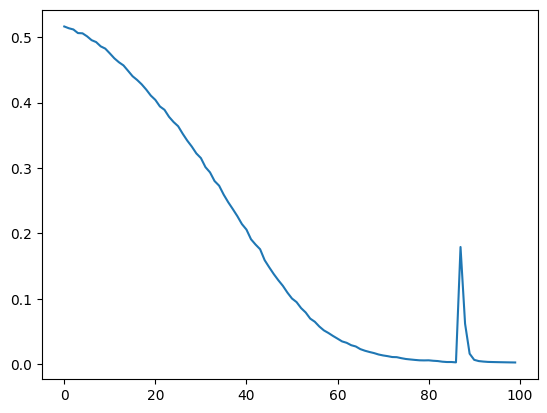

In [33]:
plt.plot(train_losses)